In [4]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import torchvision.utils as vutils

latent_dim = 100
lr = 0.0002
batch_size = 64
epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        ngf = 64
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.model(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        ndf = 64
        self.model = nn.Sequential(
            nn.Conv2d(1, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.model(input).view(-1, 1)

class GAN:
    def __init__(self, latent_dim=100, lr=0.0002):
        self.generator = Generator(latent_dim).to(device)
        self.discriminator = Discriminator().to(device)
        self.latent_dim = latent_dim

        self.criterion = nn.BCELoss()

        self.optimizer_G = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(0.5, 0.999))
        self.optimizer_D = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

real_path = './real_images'
generated_path = './generated_images'

if not os.path.exists(real_path):
    os.makedirs(real_path)
    print(f"Created directory: {real_path}")

if not os.path.exists(generated_path):
    os.makedirs(generated_path)
    print(f"Created directory: {generated_path}")

gan = GAN(latent_dim=latent_dim, lr=lr)
fixed_noise = torch.randn(25, latent_dim, 1, 1, device=device)

G_losses = []
D_losses = []

for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.to(device)

        valid = torch.ones(real_imgs.size(0), 1, device=device)
        fake = torch.zeros(real_imgs.size(0), 1, device=device)

        gan.optimizer_G.zero_grad()

        z = torch.randn(real_imgs.size(0), latent_dim, 1, 1, device=device)
        gen_imgs = gan.generator(z)

        g_loss = gan.criterion(gan.discriminator(gen_imgs), valid)

        g_loss.backward()
        gan.optimizer_G.step()

        gan.optimizer_D.zero_grad()

        real_loss = gan.criterion(gan.discriminator(real_imgs), valid)
        fake_loss = gan.criterion(gan.discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        gan.optimizer_D.step()

        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        if i % 100 == 0:
            print(f"[Epoch {epoch+1}/{epochs}] [Batch {i}/{len(dataloader)}] "
                  f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

    if epoch == 0:
        real_images_sample = next(iter(dataloader))[0]
        vutils.save_image(real_images_sample, os.path.join(real_path, 'real_sample.png'), nrow=5, normalize=True)

    with torch.no_grad():
        gen_imgs = gan.generator(fixed_noise).cpu()
    vutils.save_image(gen_imgs, os.path.join(generated_path, f'generated_sample_epoch_{epoch+1}.png'), nrow=5, normalize=True)

    grid = torchvision.utils.make_grid(gen_imgs, nrow=5, normalize=True)
    np_grid = grid.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(np_grid, (1, 2, 0)))
    plt.title(f'Epoch {epoch+1}')
    plt.axis('off')
    plt.show()

plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

print("Real images path exists:", os.path.exists(real_path))
print("Generated images path exists:", os.path.exists(generated_path))

fid_value = fid_score.calculate_fid_given_paths([real_path, generated_path], batch_size, device, dims=2048)
print(f"FID Score: {fid_value}")

torch.save(gan.generator.state_dict(), 'generator.pth')
torch.save(gan.discriminator.state_dict(), 'discriminator.pth')


[Epoch 1/10] [Batch 0/938] [D loss: 0.6906] [G loss: 0.7386]


KeyboardInterrupt: 

In [5]:
!pip install pytorch_fid


[Epoch 1/10] [Batch 0/938] [D loss: 0.6850] [G loss: 0.5153]
[Epoch 1/10] [Batch 100/938] [D loss: 0.0019] [G loss: 6.5964]
[Epoch 1/10] [Batch 200/938] [D loss: 0.2274] [G loss: 1.6455]
[Epoch 1/10] [Batch 300/938] [D loss: 0.3487] [G loss: 1.1024]
[Epoch 1/10] [Batch 400/938] [D loss: 0.1757] [G loss: 2.2711]
[Epoch 1/10] [Batch 500/938] [D loss: 0.2407] [G loss: 2.5727]
[Epoch 1/10] [Batch 600/938] [D loss: 0.2989] [G loss: 2.1919]
[Epoch 1/10] [Batch 700/938] [D loss: 0.3764] [G loss: 2.8333]
[Epoch 1/10] [Batch 800/938] [D loss: 0.2240] [G loss: 1.7933]
[Epoch 1/10] [Batch 900/938] [D loss: 0.1732] [G loss: 2.2111]


100%|██████████| 16/16 [00:03<00:00,  4.20it/s]


FID Score at Epoch 1: 270.54520335678467


[Epoch 2/10] [Batch 0/938] [D loss: 0.2398] [G loss: 1.8950]
[Epoch 2/10] [Batch 100/938] [D loss: 0.2630] [G loss: 2.7052]
[Epoch 2/10] [Batch 200/938] [D loss: 0.5317] [G loss: 0.6609]
[Epoch 2/10] [Batch 300/938] [D loss: 0.2083] [G loss: 4.1139]
[Epoch 2/10] [Batch 400/938] [D loss: 0.1966] [G loss: 1.8411]
[Epoch 2/10] [Batch 500/938] [D loss: 0.4689] [G loss: 0.7787]
[Epoch 2/10] [Batch 600/938] [D loss: 0.2526] [G loss: 1.2208]
[Epoch 2/10] [Batch 700/938] [D loss: 0.0918] [G loss: 3.3557]
[Epoch 2/10] [Batch 800/938] [D loss: 0.1365] [G loss: 2.5528]
[Epoch 2/10] [Batch 900/938] [D loss: 0.2857] [G loss: 4.2222]


100%|██████████| 16/16 [00:03<00:00,  4.19it/s]


FID Score at Epoch 2: 260.5658067341474


[Epoch 3/10] [Batch 0/938] [D loss: 0.5307] [G loss: 0.7952]
[Epoch 3/10] [Batch 100/938] [D loss: 0.0336] [G loss: 3.8621]
[Epoch 3/10] [Batch 200/938] [D loss: 0.1743] [G loss: 3.3299]
[Epoch 3/10] [Batch 300/938] [D loss: 0.0525] [G loss: 4.1859]
[Epoch 3/10] [Batch 400/938] [D loss: 0.2341] [G loss: 1.5550]
[Epoch 3/10] [Batch 500/938] [D loss: 0.1565] [G loss: 3.6922]
[Epoch 3/10] [Batch 600/938] [D loss: 0.9975] [G loss: 9.7227]
[Epoch 3/10] [Batch 700/938] [D loss: 0.1377] [G loss: 2.1505]
[Epoch 3/10] [Batch 800/938] [D loss: 0.2419] [G loss: 6.8964]
[Epoch 3/10] [Batch 900/938] [D loss: 0.3007] [G loss: 1.4084]


100%|██████████| 16/16 [00:03<00:00,  4.07it/s]


FID Score at Epoch 3: 214.4482496699177


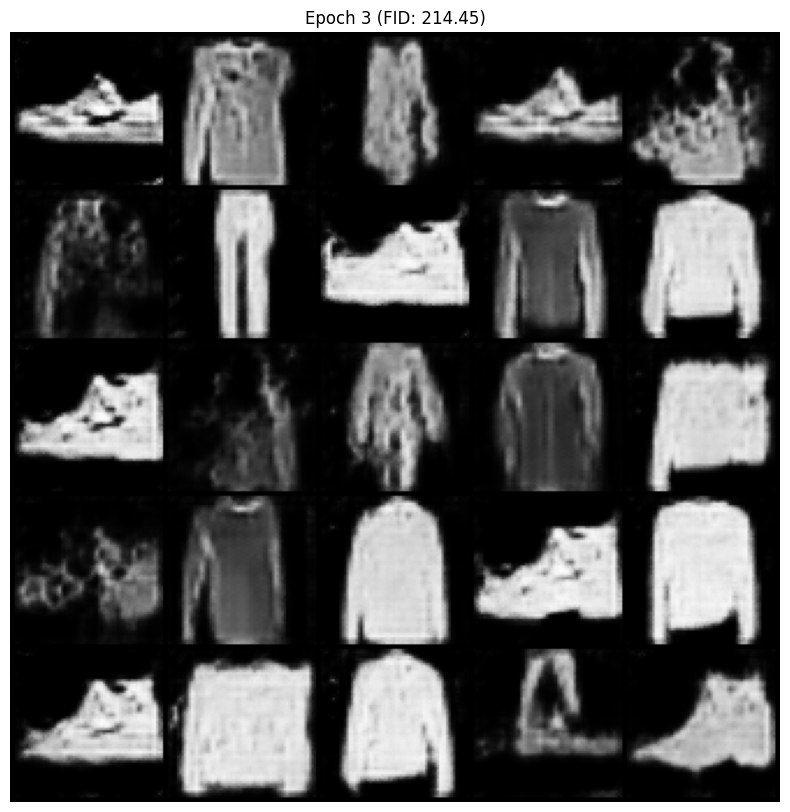

[Epoch 4/10] [Batch 0/938] [D loss: 1.9386] [G loss: 12.1816]
[Epoch 4/10] [Batch 100/938] [D loss: 0.0620] [G loss: 4.7055]
[Epoch 4/10] [Batch 200/938] [D loss: 0.0239] [G loss: 4.0781]
[Epoch 4/10] [Batch 300/938] [D loss: 0.0602] [G loss: 3.1355]
[Epoch 4/10] [Batch 400/938] [D loss: 0.0416] [G loss: 6.3100]
[Epoch 4/10] [Batch 500/938] [D loss: 0.0510] [G loss: 3.2669]
[Epoch 4/10] [Batch 600/938] [D loss: 0.1419] [G loss: 4.2425]
[Epoch 4/10] [Batch 700/938] [D loss: 0.4360] [G loss: 7.4714]
[Epoch 4/10] [Batch 800/938] [D loss: 0.0212] [G loss: 6.0123]
[Epoch 4/10] [Batch 900/938] [D loss: 0.0214] [G loss: 4.3255]


100%|██████████| 16/16 [00:03<00:00,  4.09it/s]


FID Score at Epoch 4: 219.04745538243736


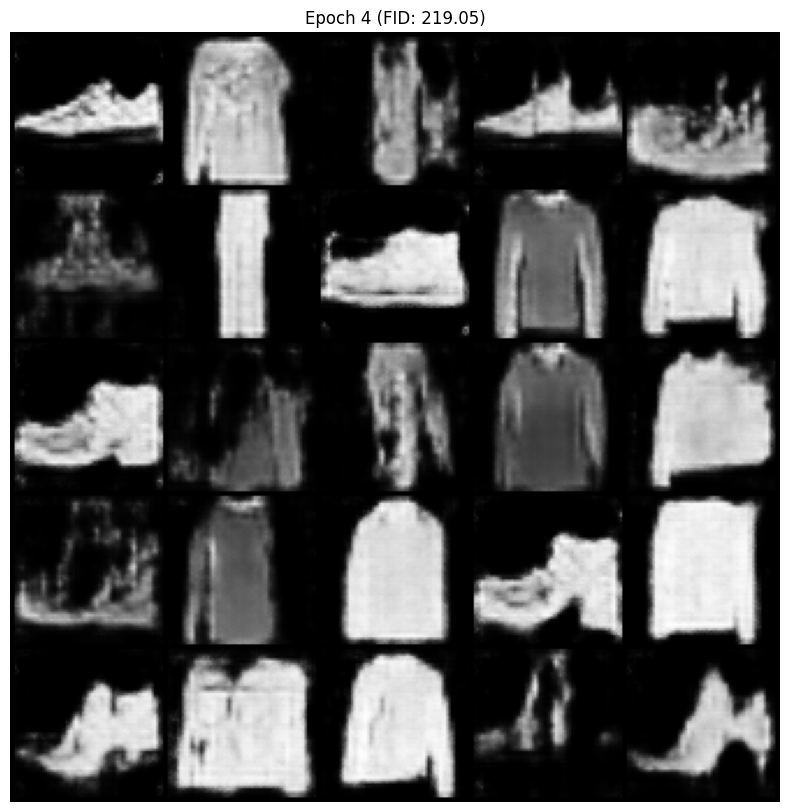

[Epoch 5/10] [Batch 0/938] [D loss: 0.0677] [G loss: 2.9622]
[Epoch 5/10] [Batch 100/938] [D loss: 0.0347] [G loss: 3.7391]
[Epoch 5/10] [Batch 200/938] [D loss: 0.0387] [G loss: 3.5322]
[Epoch 5/10] [Batch 300/938] [D loss: 0.0443] [G loss: 4.5637]
[Epoch 5/10] [Batch 400/938] [D loss: 0.0644] [G loss: 3.2474]
[Epoch 5/10] [Batch 500/938] [D loss: 0.0214] [G loss: 4.1102]
[Epoch 5/10] [Batch 600/938] [D loss: 0.0298] [G loss: 3.6904]
[Epoch 5/10] [Batch 700/938] [D loss: 0.1521] [G loss: 1.7441]
[Epoch 5/10] [Batch 800/938] [D loss: 0.1041] [G loss: 4.5219]
[Epoch 5/10] [Batch 900/938] [D loss: 0.0964] [G loss: 3.5590]


100%|██████████| 16/16 [00:03<00:00,  4.18it/s]


FID Score at Epoch 5: 201.78452480051783


[Epoch 6/10] [Batch 0/938] [D loss: 0.1694] [G loss: 7.5605]
[Epoch 6/10] [Batch 100/938] [D loss: 0.0608] [G loss: 5.8850]
[Epoch 6/10] [Batch 200/938] [D loss: 0.0896] [G loss: 3.8507]
[Epoch 6/10] [Batch 300/938] [D loss: 0.0549] [G loss: 3.2418]
[Epoch 6/10] [Batch 400/938] [D loss: 0.0243] [G loss: 4.3937]
[Epoch 6/10] [Batch 500/938] [D loss: 0.0297] [G loss: 4.4507]
[Epoch 6/10] [Batch 600/938] [D loss: 0.0444] [G loss: 3.5012]
[Epoch 6/10] [Batch 700/938] [D loss: 0.0108] [G loss: 4.8245]
[Epoch 6/10] [Batch 800/938] [D loss: 0.2283] [G loss: 2.6805]
[Epoch 6/10] [Batch 900/938] [D loss: 0.0149] [G loss: 12.2581]


100%|██████████| 16/16 [00:03<00:00,  4.09it/s]


FID Score at Epoch 6: 245.01084823855183


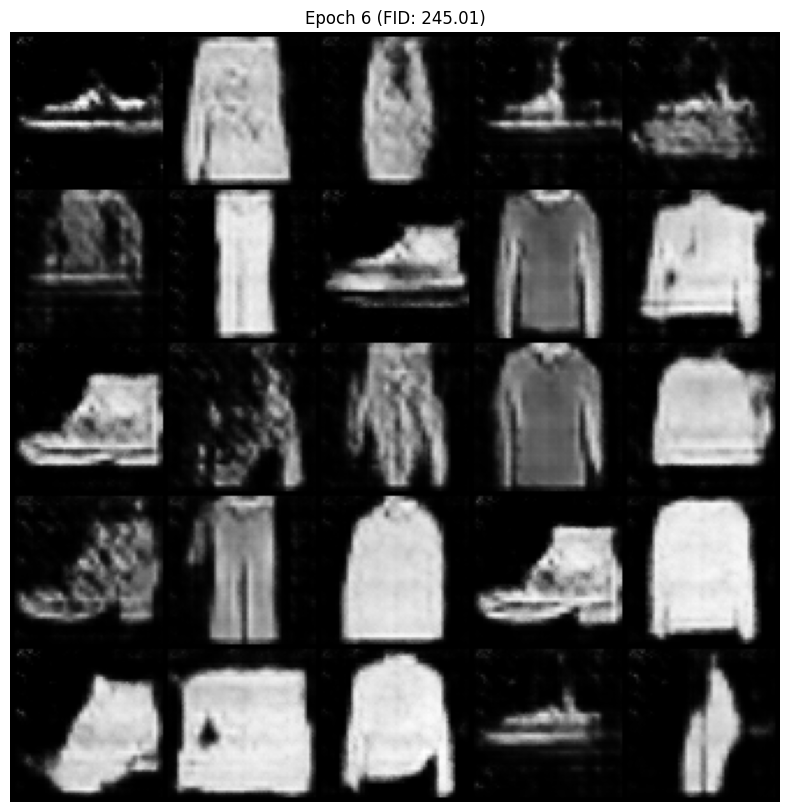

[Epoch 7/10] [Batch 0/938] [D loss: 0.0728] [G loss: 2.4976]
[Epoch 7/10] [Batch 100/938] [D loss: 0.0704] [G loss: 2.7651]
[Epoch 7/10] [Batch 200/938] [D loss: 0.0378] [G loss: 5.2361]
[Epoch 7/10] [Batch 300/938] [D loss: 0.0104] [G loss: 5.7263]
[Epoch 7/10] [Batch 400/938] [D loss: 0.0297] [G loss: 4.6377]
[Epoch 7/10] [Batch 500/938] [D loss: 0.0319] [G loss: 5.1032]
[Epoch 7/10] [Batch 600/938] [D loss: 0.0105] [G loss: 4.8852]
[Epoch 7/10] [Batch 700/938] [D loss: 0.0110] [G loss: 6.0773]
[Epoch 7/10] [Batch 800/938] [D loss: 0.1272] [G loss: 3.0038]
[Epoch 7/10] [Batch 900/938] [D loss: 0.0553] [G loss: 4.0209]


100%|██████████| 16/16 [00:03<00:00,  4.01it/s]


FID Score at Epoch 7: 246.9888497391417


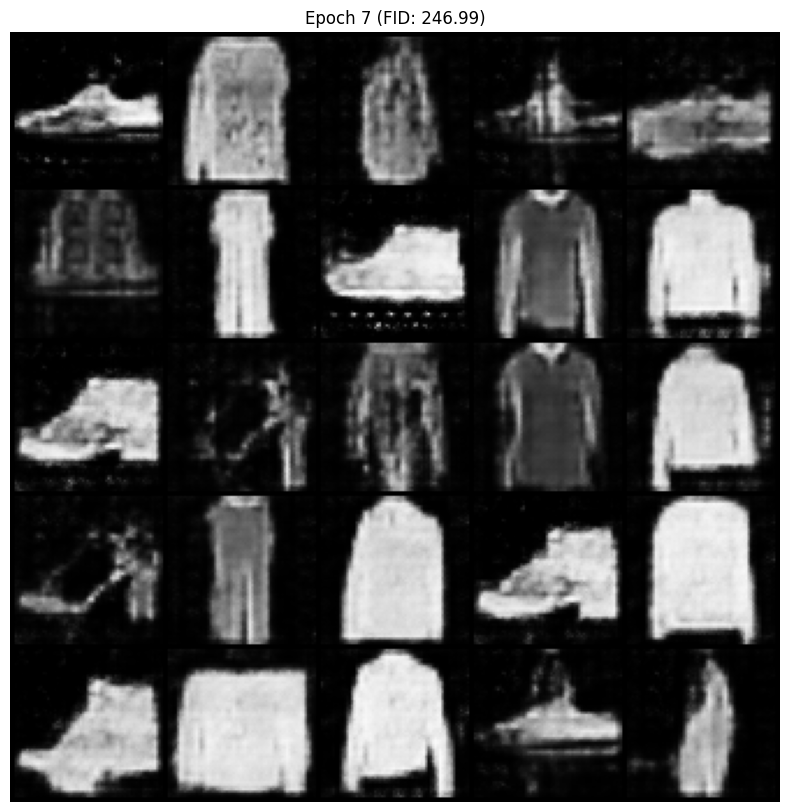

[Epoch 8/10] [Batch 0/938] [D loss: 0.1015] [G loss: 4.5179]
[Epoch 8/10] [Batch 100/938] [D loss: 0.0685] [G loss: 3.5645]
[Epoch 8/10] [Batch 200/938] [D loss: 0.0311] [G loss: 5.2496]
[Epoch 8/10] [Batch 300/938] [D loss: 0.0202] [G loss: 4.0654]
[Epoch 8/10] [Batch 400/938] [D loss: 0.0227] [G loss: 6.9933]
[Epoch 8/10] [Batch 500/938] [D loss: 0.0117] [G loss: 5.0048]
[Epoch 8/10] [Batch 600/938] [D loss: 0.0179] [G loss: 3.8939]
[Epoch 8/10] [Batch 700/938] [D loss: 0.0078] [G loss: 5.8695]
[Epoch 8/10] [Batch 800/938] [D loss: 0.0211] [G loss: 4.2555]
[Epoch 8/10] [Batch 900/938] [D loss: 0.0122] [G loss: 4.3635]


100%|██████████| 16/16 [00:03<00:00,  4.07it/s]


FID Score at Epoch 8: 171.66586564761022


[Epoch 9/10] [Batch 0/938] [D loss: 2.5724] [G loss: 12.8691]
[Epoch 9/10] [Batch 100/938] [D loss: 0.0352] [G loss: 4.4916]
[Epoch 9/10] [Batch 200/938] [D loss: 0.2343] [G loss: 2.0650]
[Epoch 9/10] [Batch 300/938] [D loss: 0.2743] [G loss: 6.8560]
[Epoch 9/10] [Batch 400/938] [D loss: 0.0056] [G loss: 6.1593]
[Epoch 9/10] [Batch 500/938] [D loss: 0.0067] [G loss: 5.4665]
[Epoch 9/10] [Batch 600/938] [D loss: 0.0478] [G loss: 5.0197]
[Epoch 9/10] [Batch 700/938] [D loss: 0.0273] [G loss: 4.8821]
[Epoch 9/10] [Batch 800/938] [D loss: 0.1245] [G loss: 3.1583]
[Epoch 9/10] [Batch 900/938] [D loss: 0.0262] [G loss: 3.9178]


100%|██████████| 16/16 [00:03<00:00,  4.11it/s]


FID Score at Epoch 9: 203.21771845425891


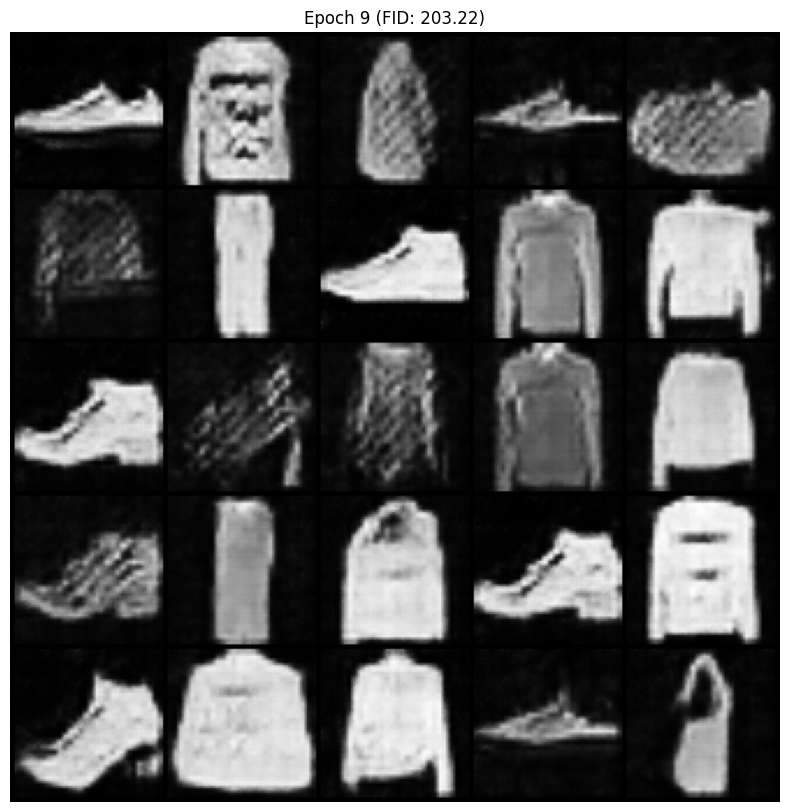

[Epoch 10/10] [Batch 0/938] [D loss: 0.0054] [G loss: 5.8442]
[Epoch 10/10] [Batch 100/938] [D loss: 0.0191] [G loss: 6.2887]
[Epoch 10/10] [Batch 200/938] [D loss: 0.0109] [G loss: 5.1476]
[Epoch 10/10] [Batch 300/938] [D loss: 0.0068] [G loss: 5.8507]
[Epoch 10/10] [Batch 400/938] [D loss: 0.0210] [G loss: 4.9215]
[Epoch 10/10] [Batch 500/938] [D loss: 5.3060] [G loss: 18.3636]
[Epoch 10/10] [Batch 600/938] [D loss: 0.0417] [G loss: 3.8732]
[Epoch 10/10] [Batch 700/938] [D loss: 0.0223] [G loss: 4.4857]
[Epoch 10/10] [Batch 800/938] [D loss: 0.0154] [G loss: 4.4551]
[Epoch 10/10] [Batch 900/938] [D loss: 0.1324] [G loss: 4.7135]


100%|██████████| 16/16 [00:03<00:00,  4.13it/s]


FID Score at Epoch 10: 208.15105861728108


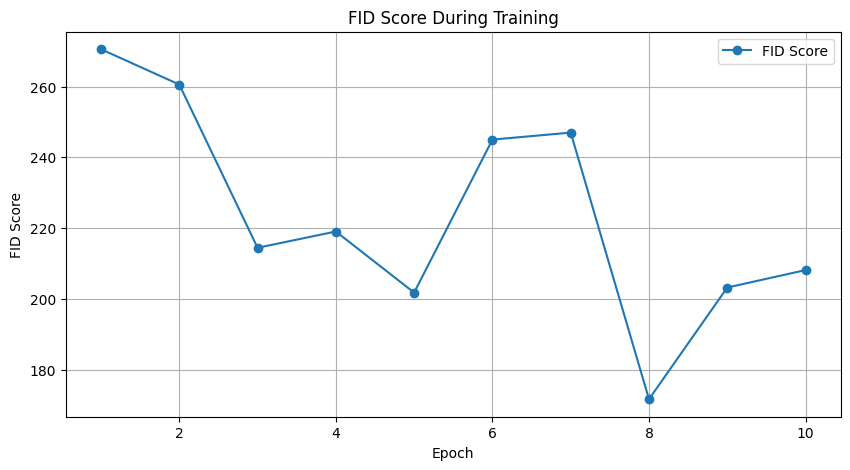

In [6]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import os
import matplotlib.pyplot as plt
from pytorch_fid import fid_score

real_path = './real_images'
generated_path_epoch = './generated_images'

os.makedirs(real_path, exist_ok=True)
os.makedirs(generated_path_epoch, exist_ok=True)

gan = GAN(latent_dim=latent_dim, lr=lr)
fixed_noise = torch.randn(25, latent_dim, 1, 1, device=device)

G_losses = []
D_losses = []
FID_scores = []

if len(os.listdir(real_path)) < 1000:
    for i, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs[:batch_size]
        for j, img in enumerate(real_imgs):
            img_resized = transforms.Resize((64, 64))(img)
            vutils.save_image(img_resized, os.path.join(real_path, f'real_img_{i * batch_size + j}.png'), normalize=True)
        if (i + 1) * batch_size >= 1000:
            break

for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.to(device)

        valid = torch.ones(real_imgs.size(0), 1, device=device)
        fake = torch.zeros(real_imgs.size(0), 1, device=device)

        gan.optimizer_G.zero_grad()
        z = torch.randn(real_imgs.size(0), latent_dim, 1, 1, device=device)
        gen_imgs = gan.generator(z)
        g_loss = gan.criterion(gan.discriminator(gen_imgs), valid)
        g_loss.backward()
        gan.optimizer_G.step()

        gan.optimizer_D.zero_grad()
        real_loss = gan.criterion(gan.discriminator(real_imgs), valid)
        fake_loss = gan.criterion(gan.discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        gan.optimizer_D.step()

        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        if i % 100 == 0:
            print(f"[Epoch {epoch+1}/{epochs}] [Batch {i}/{len(dataloader)}] "
                  f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

    generated_epoch_dir = os.path.join(generated_path_epoch, f'epoch_{epoch+1}')
    os.makedirs(generated_epoch_dir, exist_ok=True)

    with torch.no_grad():
        for j in range(0, 1000, batch_size):
            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            gen_imgs = gan.generator(noise).cpu()
            for k, img in enumerate(gen_imgs):
                img_resized = transforms.Resize((64, 64))(img)
                vutils.save_image(img_resized, os.path.join(generated_epoch_dir, f'img_{j + k}.png'), normalize=True)
            if (j + batch_size) >= 1000:
                break

    fid_value = fid_score.calculate_fid_given_paths(
        [real_path, generated_epoch_dir],
        batch_size=min(batch_size, len(os.listdir(real_path)), len(os.listdir(generated_epoch_dir))),
        device=device,
        dims=2048
    )
    FID_scores.append(fid_value)
    print(f"FID Score at Epoch {epoch+1}: {fid_value}")

    with torch.no_grad():
        gen_imgs = gan.generator(fixed_noise).cpu()
    grid = vutils.make_grid(gen_imgs, nrow=5, normalize=True)
    np_grid = grid.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(np_grid, (1, 2, 0)))
    plt.title(f'Epoch {epoch+1} (FID: {fid_value:.2f})')
    plt.axis('off')
    plt.show()

plt.figure(figsize=(10, 5))
plt.title("FID Score During Training")
plt.plot(range(1, epochs + 1), FID_scores, marker='o', label="FID Score")
plt.xlabel("Epoch")
plt.ylabel("FID Score")
plt.legend()
plt.grid()
plt.show()

torch.save(gan.generator.state_dict(), 'generator.pth')
torch.save(gan.discriminator.state_dict(), 'discriminator.pth')